In [57]:
import multiprocessing
import pandas as pd
import numpy as np
import subprocess
import random
from scipy import stats
import glob
import math
import csv
import sys
import os

import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.family'] = "serif"
%matplotlib inline

In [58]:
# declarations
out_dir = "/ccb/salz8-1/avaraby/tx_noise/full_analysis_t3_s10_26022020/sim_samples/"
annotation = "/ccb/salz8-1/avaraby/tx_noise/data/chess2.2_assembly.gff"

gr_path = "/ccb/salz8-1/avaraby/tx_noise/soft/get_results/get_results"

num_tissues = 3
num_samples = 10

num_processes = 5

gff3cols=["seqid","source","type","start","end","score","strand","phase","attributes"]

# bcbioRnaseq - both salmon and kallisto can be aggregated to the gene-level
# https://github.com/bcbio/bcbio-nextgen/issues/2077

In [59]:
# begin by loading the real data
strg_real = pd.DataFrame()
slmn_real = pd.DataFrame()
klst_real = pd.DataFrame()
for tn in range(num_tissues):
    for sn in range(num_samples):
        tmp = pd.read_csv(out_dir+"strg_real.t"+str(tn)+"_s"+str(sn)+".csv")
        strg_real = pd.concat([strg_real,tmp],axis=0)
        
        tmp = pd.read_csv(out_dir+"slmn_real.t"+str(tn)+"_s"+str(sn)+".csv")
        slmn_real = pd.concat([slmn_real,tmp],axis=0)
        
        tmp = pd.read_csv(out_dir+"klst_real.t"+str(tn)+"_s"+str(sn)+".csv")
        klst_real = pd.concat([klst_real,tmp],axis=0)

In [60]:
# now load the all data
strg_all = pd.DataFrame()
slmn_all = pd.DataFrame()
klst_all = pd.DataFrame()
for tn in range(num_tissues):
    for sn in range(num_samples):
        tmp = pd.read_csv(out_dir+"strg_all.t"+str(tn)+"_s"+str(sn)+".csv")
        strg_all = pd.concat([strg_all,tmp],axis=0)
        
        tmp = pd.read_csv(out_dir+"slmn_all.t"+str(tn)+"_s"+str(sn)+".csv")
        slmn_all = pd.concat([slmn_all,tmp],axis=0)
        
        tmp = pd.read_csv(out_dir+"klst_all.t"+str(tn)+"_s"+str(sn)+".csv")
        klst_all = pd.concat([klst_all,tmp],axis=0)

In [61]:
# now we need to extract median, quartiles and whiskers

# calculate whiskers
def calcWhisk(row,data):
    iqr = row["q75"] - row["q25"]
    lowWhisker = float(row["q25"])-1.5*float(iqr)
    highWhisker = float(row["q75"])+1.5*float(iqr)

    wiskhi = np.max(data[data["fold"]<=highWhisker]["fold"])
    wisklo = np.min(data[data["fold"]>=lowWhisker]["fold"])
    extremesHigh = data[data["fold"]>wiskhi]["fold"].tolist()
    extremesLow = data[data["fold"]<wisklo]["fold"].tolist()

    return [wisklo,wiskhi,extremesLow+extremesHigh]

strg_real_g=pd.DataFrame([])
for frac_real in set(strg_real["frac_real"]):
    stats=pd.DataFrame()
    stats_all=strg_real[strg_real["frac_real"]==frac_real][["frac_real","fold"]].reset_index(drop=True)
    stats["q25"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.25)).reset_index()["fold"]
    stats["median"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.50)).reset_index()["fold"]
    stats["q75"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.75)).reset_index()["fold"]
    stats["mean"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].mean()).reset_index()["fold"]
    stats[['whiskLow','whiskHigh','extremes']] = pd.DataFrame([x for x in stats.apply(lambda row: calcWhisk(row,stats_all),axis=1)])
    stats["frac_real"]=frac_real
    strg_real_g=pd.concat([strg_real_g,stats])
strg_real_g.sort_values(by="frac_real",inplace=True)

slmn_real_g=pd.DataFrame([])
for frac_real in set(slmn_real["frac_real"]):
    stats=pd.DataFrame()
    stats_all=slmn_real[slmn_real["frac_real"]==frac_real][["frac_real","fold"]].reset_index(drop=True)
    stats["q25"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.25)).reset_index()["fold"]
    stats["median"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.50)).reset_index()["fold"]
    stats["q75"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.75)).reset_index()["fold"]
    stats["mean"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].mean()).reset_index()["fold"]
    stats[['whiskLow','whiskHigh','extremes']] = pd.DataFrame([x for x in stats.apply(lambda row: calcWhisk(row,stats_all),axis=1)])
    stats["frac_real"]=frac_real
    slmn_real_g=pd.concat([slmn_real_g,stats])
slmn_real_g.sort_values(by="frac_real",inplace=True)

klst_real_g=pd.DataFrame([])
for frac_real in set(klst_real["frac_real"]):
    stats=pd.DataFrame()
    stats_all=klst_real[klst_real["frac_real"]==frac_real][["frac_real","fold"]].reset_index(drop=True)
    stats["q25"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.25)).reset_index()["fold"]
    stats["median"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.50)).reset_index()["fold"]
    stats["q75"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.75)).reset_index()["fold"]
    stats["mean"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].mean()).reset_index()["fold"]
    stats[['whiskLow','whiskHigh','extremes']] = pd.DataFrame([x for x in stats.apply(lambda row: calcWhisk(row,stats_all),axis=1)])
    stats["frac_real"]=frac_real
    klst_real_g=pd.concat([klst_real_g,stats])
klst_real_g.sort_values(by="frac_real",inplace=True)

strg_all_g=pd.DataFrame([])
for frac_real in set(strg_all["frac_real"]):
    stats=pd.DataFrame()
    stats_all=strg_all[strg_all["frac_real"]==frac_real][["frac_real","fold"]].reset_index(drop=True)
    stats["q25"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.25)).reset_index()["fold"]
    stats["median"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.50)).reset_index()["fold"]
    stats["q75"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.75)).reset_index()["fold"]
    stats["mean"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].mean()).reset_index()["fold"]
    stats[['whiskLow','whiskHigh','extremes']] = pd.DataFrame([x for x in stats.apply(lambda row: calcWhisk(row,stats_all),axis=1)])
    stats["frac_real"]=frac_real
    strg_all_g=pd.concat([strg_all_g,stats])
strg_all_g.sort_values(by="frac_real",inplace=True)

slmn_all_g=pd.DataFrame([])
for frac_real in set(slmn_all["frac_real"]):
    stats=pd.DataFrame()
    stats_all=slmn_all[slmn_all["frac_real"]==frac_real][["frac_real","fold"]].reset_index(drop=True)
    stats["q25"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.25)).reset_index()["fold"]
    stats["median"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.50)).reset_index()["fold"]
    stats["q75"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.75)).reset_index()["fold"]
    stats["mean"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].mean()).reset_index()["fold"]
    stats[['whiskLow','whiskHigh','extremes']] = pd.DataFrame([x for x in stats.apply(lambda row: calcWhisk(row,stats_all),axis=1)])
    stats["frac_real"]=frac_real
    slmn_all_g=pd.concat([slmn_all_g,stats])
slmn_all_g.sort_values(by="frac_real",inplace=True)

klst_all_g=pd.DataFrame([])
for frac_real in set(klst_all["frac_real"]):
    stats=pd.DataFrame()
    stats_all=klst_all[klst_all["frac_real"]==frac_real][["frac_real","fold"]].reset_index(drop=True)
    stats["q25"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.25)).reset_index()["fold"]
    stats["median"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.50)).reset_index()["fold"]
    stats["q75"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.75)).reset_index()["fold"]
    stats["mean"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].mean()).reset_index()["fold"]
    stats[['whiskLow','whiskHigh','extremes']] = pd.DataFrame([x for x in stats.apply(lambda row: calcWhisk(row,stats_all),axis=1)])
    stats["frac_real"]=frac_real
    klst_all_g=pd.concat([klst_all_g,stats])
klst_all_g.sort_values(by="frac_real",inplace=True)

slmn_all_g

,q25,median,q75,mean,whiskLow,whiskHigh,extremes,frac_real
0,8.560035,19.014851,37.657679,93.509399,0.109091,81.111110,"[85.21567860130719, 353.16234429870127, 94.854...",0.0
0,3.522989,6.010930,8.475669,6.776575,0.117647,15.879029,"[51.62950066666667, 20.130409590909096, 17.095...",0.1
0,2.326647,3.479798,4.406777,3.654369,0.048276,7.352013,"[8.249545181818181, 8.4, 9.27906976744186, 8.0...",0.2
0,1.882084,2.498330,2.997395,2.644048,0.211510,4.609961,"[0.13125763125763126, 0.08813646055437101, 0.0...",0.3
0,1.582500,1.977839,2.281800,2.022787,0.540984,3.325618,"[0.2258064516129032, 0.22420907840440168, 0.52...",0.4
0,1.359070,1.648158,1.858152,1.630319,0.618060,2.604374,"[0.2, 0.2832699619771863, 0.375, 0.58510636170...",0.5
0,1.203149,1.411673,1.566410,1.421474,0.658307,2.107977,"[0.6560486849159808, 0.4751553775750441, 0.631...",0.6
0,1.095555,1.257439,1.362421,1.251836,0.696013,1.760818,"[0.620253164556962, 0.5557035421568626, 0.3256...",0.7
0,1.007505,1.139067,1.212420,1.097836,0.700421,1.519136,"[0.5408477313521194, 0.5325423654237288, 0.498...",0.8
0,0.919082,1.043331,1.095651,0.988813,0.654260,1.359073,"[0.6422542755896992, 0.4932975978552279, 0.434...",0.9


[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


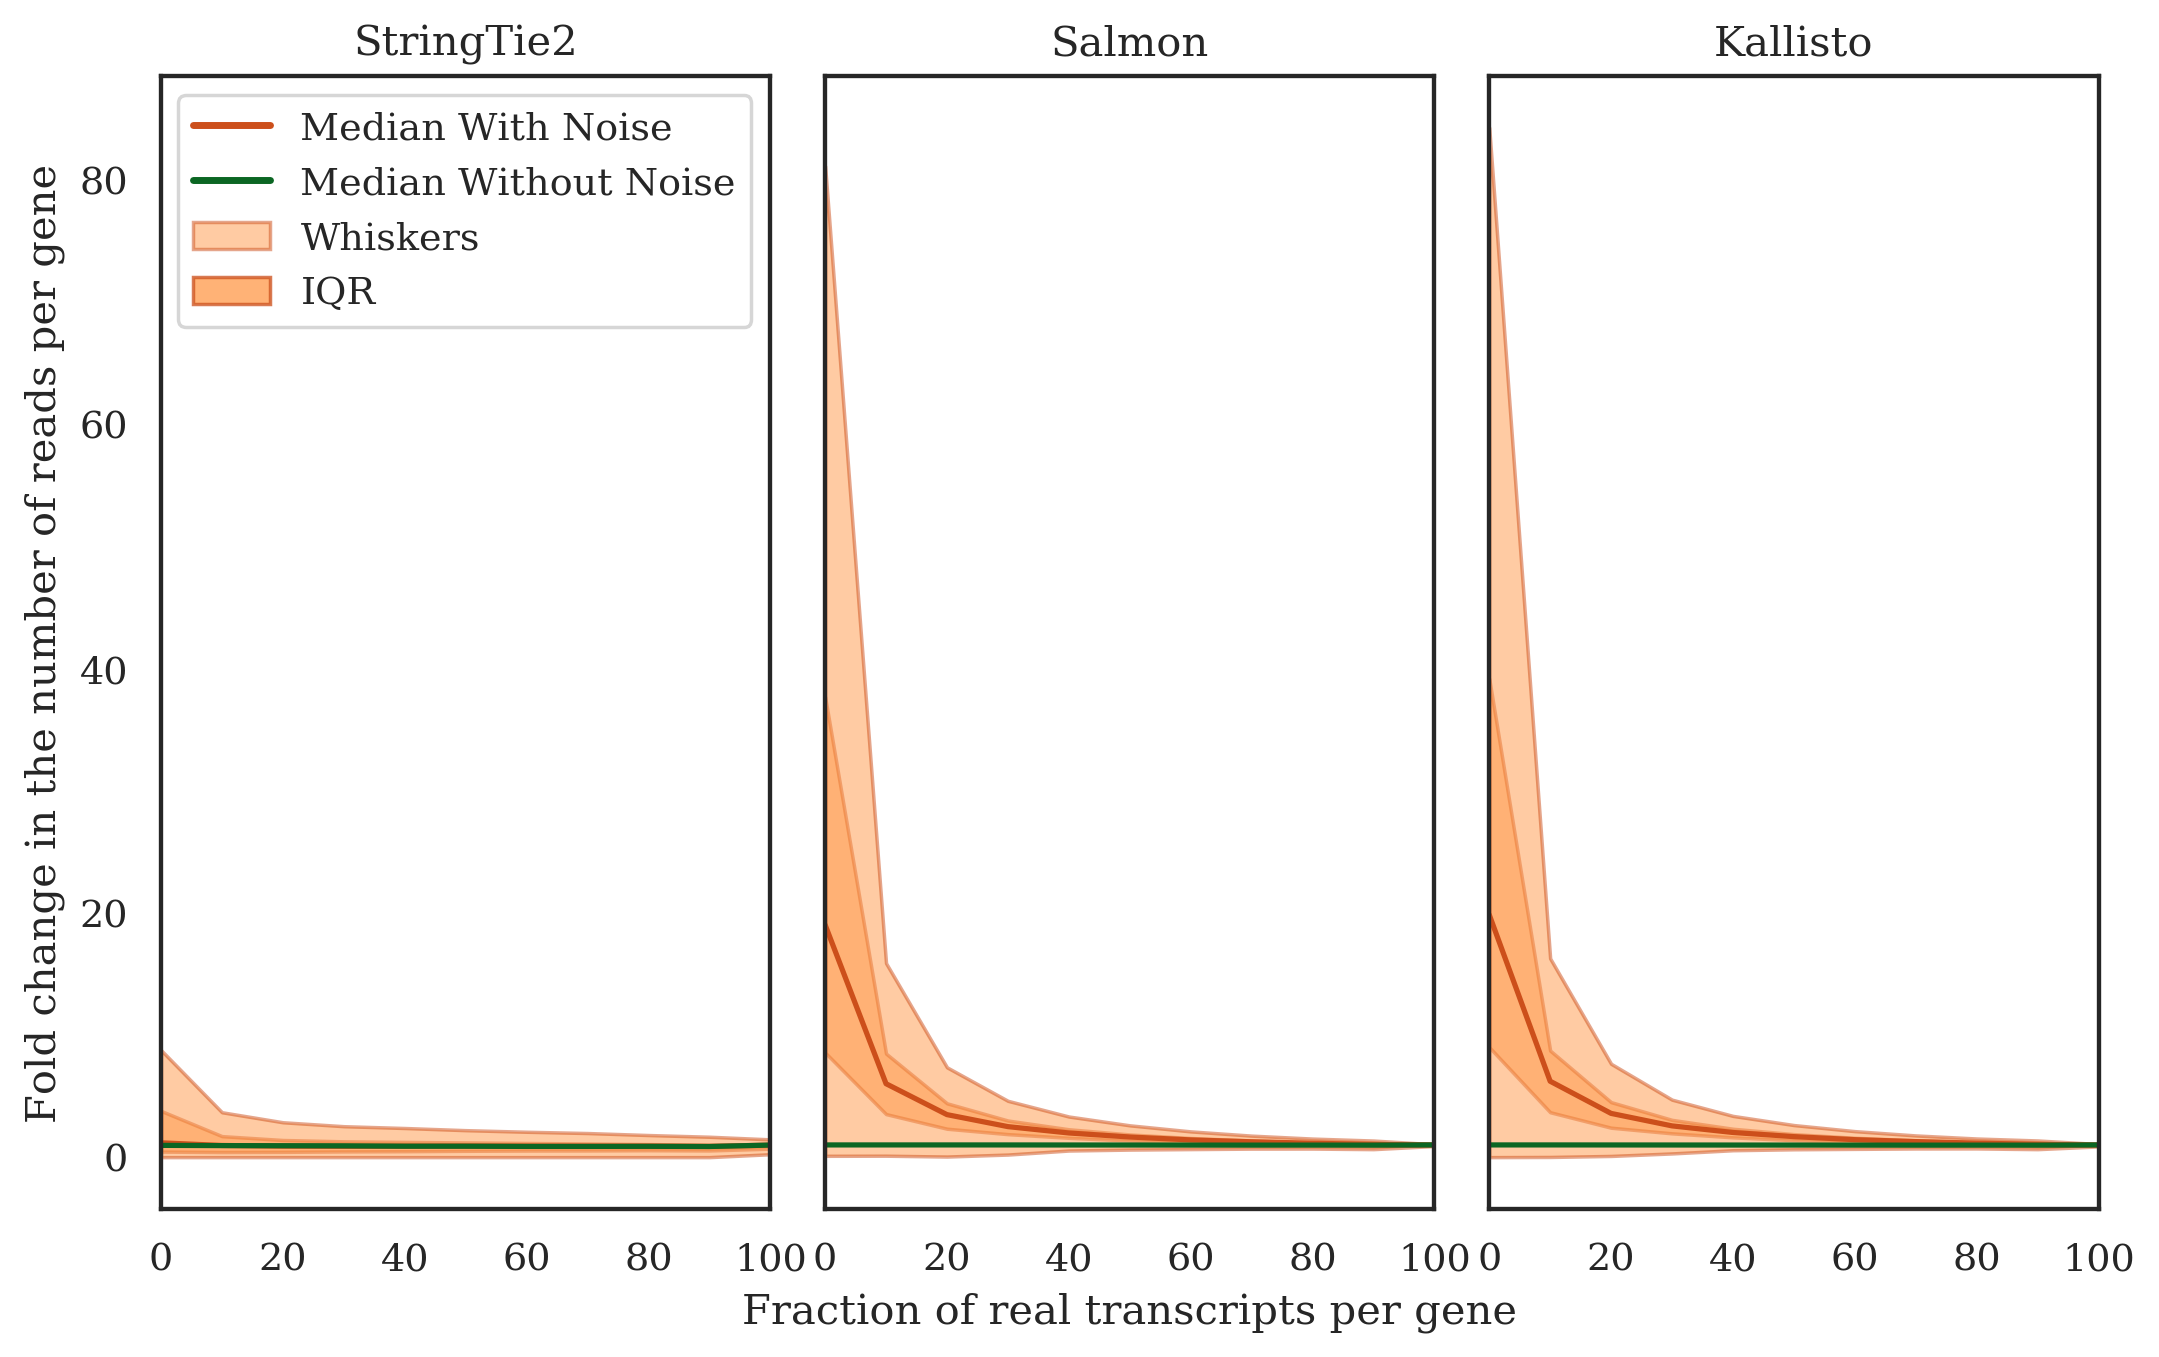

In [62]:
###### now we can finally plot everything
fig,axes = plt.subplots(nrows=1,ncols=3,sharey=True,sharex=True,figsize=(10,6),dpi=250)

# fig.suptitle("Change in gene-level expression estimate from truth as a function\nof the fraction of real transcription per gene", fontsize=16)

ticks = [int(x*100) for x in strg_all_g["frac_real"]]
print(ticks)

axes[0].plot(ticks, strg_all_g["median"],'k',color='#CC4F1B',label="with noise")
axes[0].plot(ticks, strg_real_g["median"],'k',color='#0B6623',label="without noise")
axes[0].set_xticks(ticks)
axes[0].fill_between(ticks, strg_all_g["q25"], strg_all_g["q75"],
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
axes[0].fill_between(ticks, strg_all_g["whiskLow"], strg_all_g["whiskHigh"],
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
axes[0].set_title("StringTie2")
axes[0].set_ylabel("Fold change in the number of reads per gene")

axes[1].plot(ticks, slmn_all_g["median"],'k',color='#CC4F1B')
axes[1].plot(ticks, slmn_real_g["median"],'k',color='#0B6623')
axes[1].set_xticks(ticks)
axes[1].fill_between(ticks, slmn_all_g["q25"], slmn_all_g["q75"],
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
axes[1].fill_between(ticks, slmn_all_g["whiskLow"], slmn_all_g["whiskHigh"],
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
axes[1].set_title("Salmon")
axes[1].set_xlabel("Fraction of real transcripts per gene")

axes[2].plot(ticks, klst_all_g["median"],'k',color='#CC4F1B')
axes[2].plot(ticks, klst_real_g["median"],'k',color='#0B6623')
plt.xlim(min(ticks),max(ticks))
axes[2].set_xticks(ticks)
axes[2].fill_between(ticks, klst_all_g["q25"], klst_all_g["q75"],
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
axes[2].fill_between(ticks, klst_all_g["whiskLow"], klst_all_g["whiskHigh"],
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
axes[2].set_title("Kallisto")

legend_elements = [Line2D([0], [0], color='#CC4F1B', lw=2, label='Median With Noise'),
                   Line2D([0], [0], color='#0B6623', lw=2, label='Median Without Noise'),
                   Patch(facecolor='#FF9848', edgecolor='#CC4F1B',alpha=0.5,label='Whiskers'),
                   Patch(facecolor='#FF9848', edgecolor='#CC4F1B',alpha=0.75,label='IQR')]
axes[0].legend(handles=legend_elements)

axes[0].xaxis.set_major_locator(MultipleLocator(20))
axes[0].xaxis.set_minor_locator(MultipleLocator(10))

# plt.tight_layout()
plt.subplots_adjust(wspace = .09)

In [63]:
# now need to plot false positives and false negatives
strg_real_nfp = []
slmn_real_nfp = []
klst_real_nfp = []

strg_real_nfn = []
slmn_real_nfn = []
klst_real_nfn = []

strg_all_nfp = []
slmn_all_nfp = []
klst_all_nfp = []

strg_all_nfn = []
slmn_all_nfn = []
klst_all_nfn = []
for tn in range(num_tissues):
    for sn in range(num_samples):
        strg_real_nfp.append(len(pd.read_csv(out_dir+"fp_strg_real.t"+str(tn)+"_s"+str(sn)+".csv")))
        slmn_real_nfp.append(len(pd.read_csv(out_dir+"fp_slmn_real.t"+str(tn)+"_s"+str(sn)+".csv")))
        klst_real_nfp.append(len(pd.read_csv(out_dir+"fp_klst_real.t"+str(tn)+"_s"+str(sn)+".csv")))

        strg_all_nfp.append(len(pd.read_csv(out_dir+"fp_strg_all.t"+str(tn)+"_s"+str(sn)+".csv")))
        slmn_all_nfp.append(len(pd.read_csv(out_dir+"fp_slmn_all.t"+str(tn)+"_s"+str(sn)+".csv")))
        klst_all_nfp.append(len(pd.read_csv(out_dir+"fp_klst_all.t"+str(tn)+"_s"+str(sn)+".csv")))

        strg_real_nfn.append(len(pd.read_csv(out_dir+"fn_strg_real.t"+str(tn)+"_s"+str(sn)+".csv")))
        slmn_real_nfn.append(len(pd.read_csv(out_dir+"fn_slmn_real.t"+str(tn)+"_s"+str(sn)+".csv")))
        klst_real_nfn.append(len(pd.read_csv(out_dir+"fn_klst_real.t"+str(tn)+"_s"+str(sn)+".csv")))

        strg_all_nfn.append(len(pd.read_csv(out_dir+"fn_strg_all.t"+str(tn)+"_s"+str(sn)+".csv")))
        slmn_all_nfn.append(len(pd.read_csv(out_dir+"fn_slmn_all.t"+str(tn)+"_s"+str(sn)+".csv")))
        klst_all_nfn.append(len(pd.read_csv(out_dir+"fn_klst_all.t"+str(tn)+"_s"+str(sn)+".csv")))

In [64]:
# now build dataframe for fps and fns separate and plot them into 2 columns of a figure
strg_real_nfp_df = pd.DataFrame(strg_real_nfp)
strg_real_nfp_df["method"]="StringTie2"
strg_real_nfp_df["type"]="Real"
slmn_real_nfp_df = pd.DataFrame(slmn_real_nfp)
slmn_real_nfp_df["method"]="Salmon"
slmn_real_nfp_df["type"]="Real"
klst_real_nfp_df = pd.DataFrame(klst_real_nfp)
klst_real_nfp_df["method"]="Kallisto"
klst_real_nfp_df["type"]="Real"

strg_all_nfp_df = pd.DataFrame(strg_all_nfp)
strg_all_nfp_df["method"]="StringTie2"
strg_all_nfp_df["type"]="All"
slmn_all_nfp_df = pd.DataFrame(slmn_all_nfp)
slmn_all_nfp_df["method"]="Salmon"
slmn_all_nfp_df["type"]="All"
klst_all_nfp_df = pd.DataFrame(klst_all_nfp)
klst_all_nfp_df["method"]="Kallisto"
klst_all_nfp_df["type"]="All"


strg_real_nfn_df = pd.DataFrame(strg_real_nfn)
strg_real_nfn_df["method"]="StringTie2"
strg_real_nfn_df["type"]="Real"
slmn_real_nfn_df = pd.DataFrame(slmn_real_nfn)
slmn_real_nfn_df["method"]="Salmon"
slmn_real_nfn_df["type"]="Real"
klst_real_nfn_df = pd.DataFrame(klst_real_nfn)
klst_real_nfn_df["method"]="Kallisto"
klst_real_nfn_df["type"]="Real"

strg_all_nfn_df = pd.DataFrame(strg_all_nfn)
strg_all_nfn_df["method"]="StringTie2"
strg_all_nfn_df["type"]="All"
slmn_all_nfn_df = pd.DataFrame(slmn_all_nfn)
slmn_all_nfn_df["method"]="Salmon"
slmn_all_nfn_df["type"]="All"
klst_all_nfn_df = pd.DataFrame(klst_all_nfn)
klst_all_nfn_df["method"]="Kallisto"
klst_all_nfn_df["type"]="All"

fp_df = pd.concat([strg_real_nfp_df,slmn_real_nfp_df,klst_real_nfp_df,strg_all_nfp_df,slmn_all_nfp_df,klst_all_nfp_df])
fn_df = pd.concat([strg_real_nfn_df,slmn_real_nfn_df,klst_real_nfn_df,strg_all_nfn_df,slmn_all_nfn_df,klst_all_nfn_df])
fp_df.columns = ["nfp","method","type"]
fn_df.columns = ["nfn","method","type"]
fp_df.head()

,nfp,method,type
0,906,StringTie2,Real
1,915,StringTie2,Real
2,1004,StringTie2,Real
3,956,StringTie2,Real
4,967,StringTie2,Real


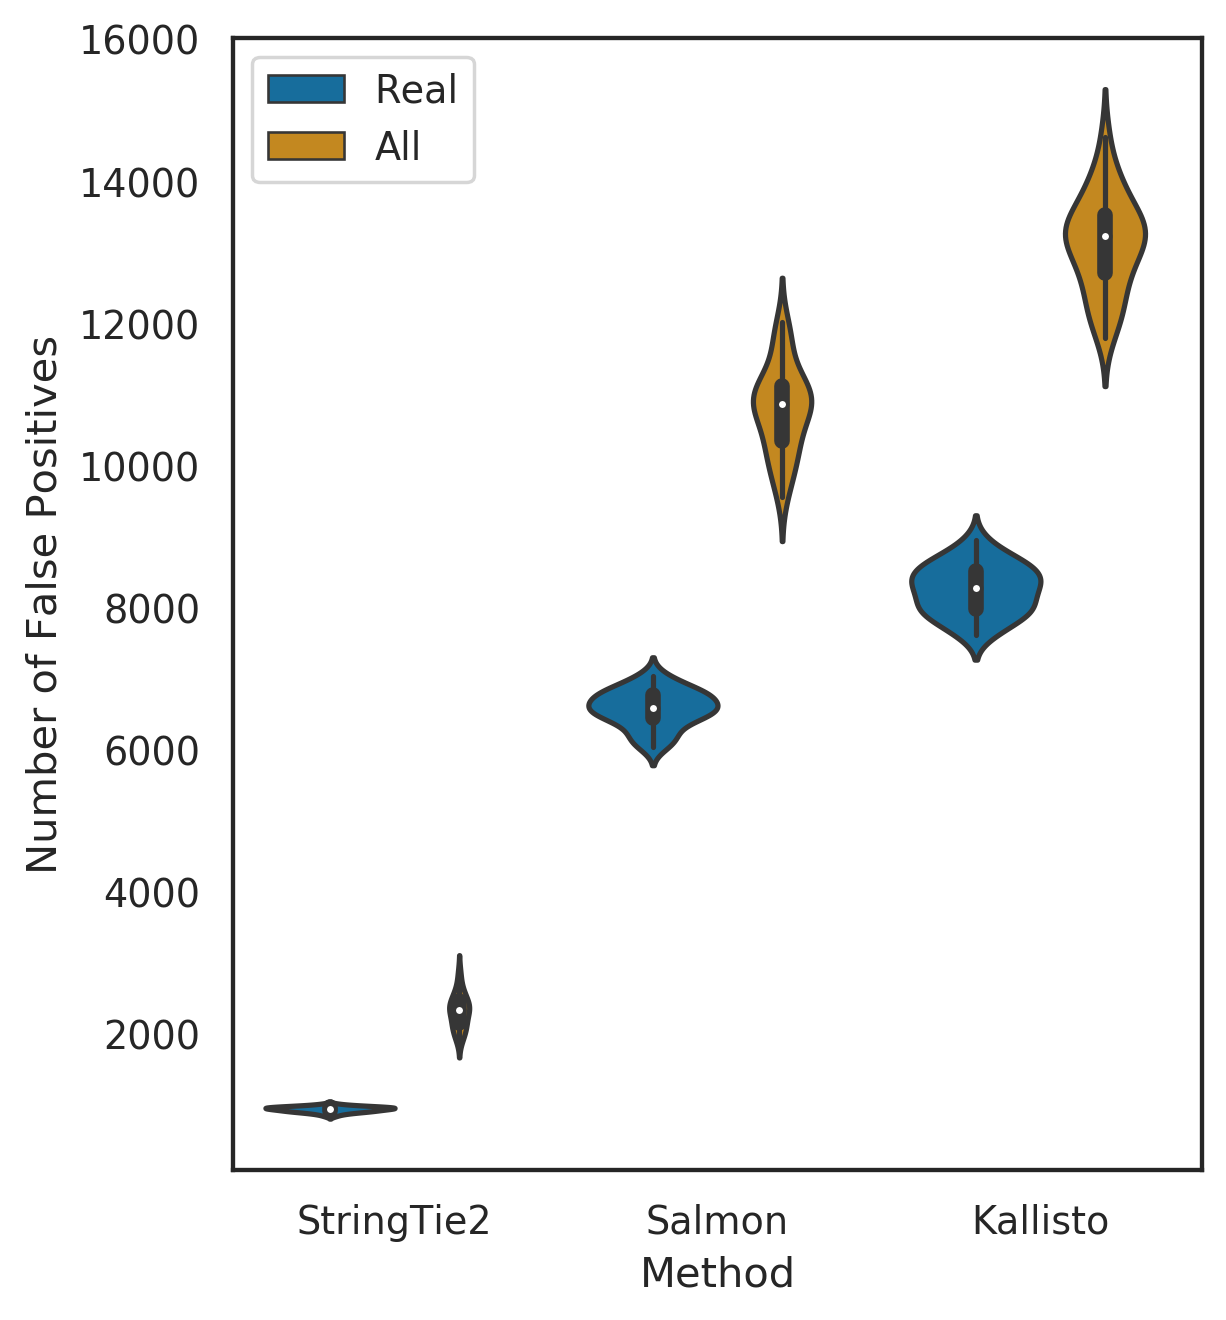

In [65]:
fig = plt.figure(figsize=(5,6),dpi=250)
sns.set(style="white", palette="colorblind", color_codes=True)
sns.violinplot(x="method", y="nfp", hue="type",data=fp_df)
plt.xlabel("Method")
# plt.title("Rate of False Positive Gene Quantification")
plt.ylabel("Number of False Positives")
legend = plt.legend()

In [66]:
# pull out a sample with the highest rate of false positives
fp_df.sort_values(by="nfp")

,nfp,method,type
5,840,StringTie2,Real
14,869,StringTie2,Real
22,874,StringTie2,Real
11,891,StringTie2,Real
25,897,StringTie2,Real
...,...,...,...
2,13821,Kallisto,All
8,13952,Kallisto,All
13,14021,Kallisto,All
3,14162,Kallisto,All


In [74]:
pd.read_csv(out_dir+"fp_klst_real.t0_s0.csv").sort_values(by="klst_nreads_real")

,gid,sim_nreads,strg_nreads_real,slmn_nreads_real,klst_nreads_real,strg_nreads_all,slmn_nreads_all,klst_nreads_all
3562,CHS.32527,0,0.000000,1.980000,0.000001,0.000000,25.780001,19.235001
3729,CHS.33673,0,0.327942,0.000000,0.000002,0.152839,0.000000,19.691500
7314,CHS.59322,0,28.385073,0.000000,0.000015,45.647939,416.222000,422.920003
6571,CHS.54388,0,0.000000,0.000000,0.000022,0.000000,0.000000,0.000000
6123,CHS.51294,0,0.000000,0.000000,0.000048,1162.115479,1529.407959,1626.000000
...,...,...,...,...,...,...,...,...
5037,CHS.42690,0,20986.890625,20812.003906,20736.599609,6655.928223,87124.007812,86268.398438
2042,CHS.22793,0,29565.095703,29432.000000,29324.000000,29565.095703,29432.000000,29330.900391
704,CHS.14968,0,43.219144,38711.000000,39011.430664,41.073741,38711.000000,39011.759766
5531,CHS.46180,0,0.000000,52507.999023,52968.008254,0.000000,52507.999023,52967.994531


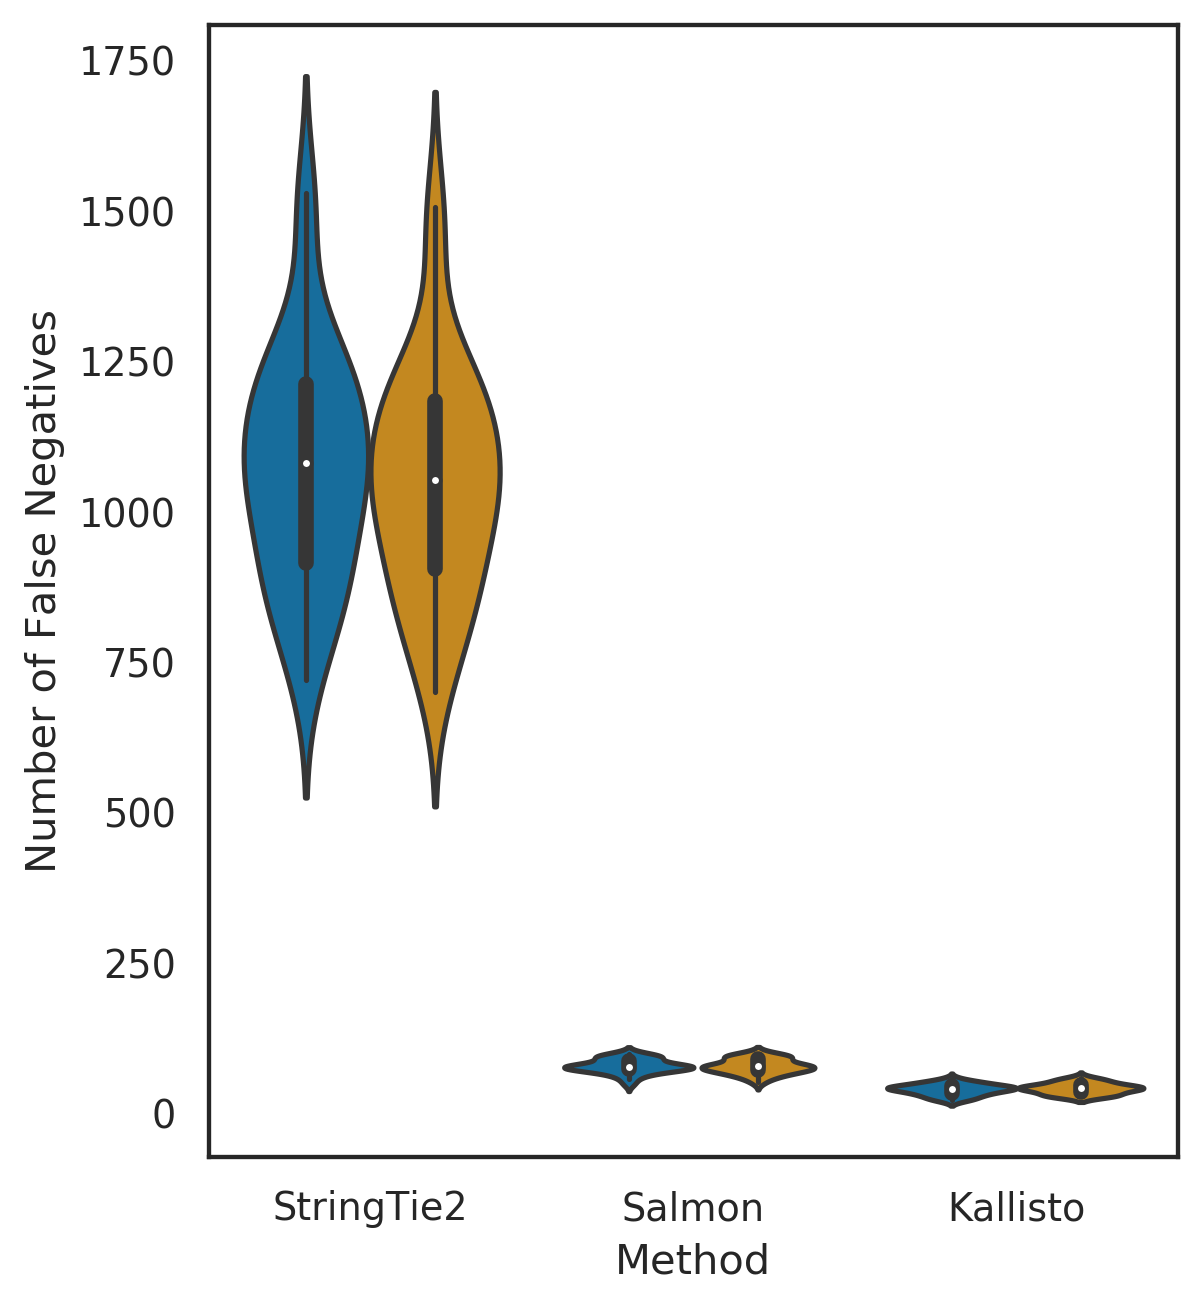

In [56]:
fig = plt.figure(figsize=(5,6),dpi=250)
sns.violinplot(x="method", y="nfn", hue="type",data=fn_df)
# plt.title("Rate of False negative Gene Quantification")
plt.xlabel("Method")
plt.ylabel("Number of False Negatives")
legend = plt.legend()
plt.legend().remove()